In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [24]:
def get_patch(img, seg, size=50):
    def rand_seg(d, l):
        lower = 0
        upper = d - l
        idx = random.randint(lower, upper)
        idx = random.randint(lower, upper)
        return idx, idx + l
    d1, d2, d3 = img.shape
    s1, s2, s3 = [rand_seg(d, size) for d in [d1, d2, d3]]
    l1, u1 = s1
    l2, u2 = s2
    l3, u3 = s3
    imgp, segp = img[l1:u1, l2:u2, l3:u3], seg[l1:u1, l2:u2, l3:u3]
    return (imgp - imgp.mean())[None, None, ...] / imgp.std(), segp[None, None, ...]

In [25]:
syn1 = 'synthetic_data/raw/1.nii.gz'
syn1_seg = 'synthetic_data/seg/1.nii.gz'
raw = 'validation_data/imageData.nii'
seg = 'validation_data/segmentationData.nii'
x, y = nib.load(syn1).get_fdata(), nib.load(syn1_seg).get_fdata()
xt, yt = nib.load(raw).get_fdata(), nib.load(seg).get_fdata()

In [36]:
class Model(nn.Module):
    def __init__(self, n_layers, size):
        super().__init__()
        self.size = size
        self.conv_in = torch.nn.Conv3d(1, 32, 1)
        self.convs = nn.ModuleList([
            torch.nn.Conv3d(32, 32, 3, padding=1) for _ in range(n_layers)
        ])
        self.conv_out = torch.nn.Conv3d(32, 1, 1)

    def forward(self, x):
        x = self.conv_in(x)
        x = F.leaky_relu(x)
        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x)
        x = self.conv_out(x)
        return x

m = Model(5, 50).cuda()
opt = torch.optim.Adam(m.parameters(), lr=0.001)
for i in range(10000):
    opt.zero_grad()
    xp, yp = get_patch(x, y)
    yp = torch.tensor(yp).cuda()
    o = m(torch.tensor(xp.astype('float32')).cuda())
    loss = F.binary_cross_entropy_with_logits(o, yp)
    loss.backward()
    opt.step()
    print(loss.cpu().detach().numpy())
    
    

63446003638985
0.00042880953270907525
0.0002973305439291329
0.0005967042335889023
0.00033190957016489107
0.00037833724591434083
0.00037951810295337284
0.00016533973071153124
0.0004398297748054125
0.000714309564053273
0.0003064440259021632
0.0002656585864766358
0.00037947412426325716
0.00040294348716292194
0.0006130085479219098
0.0016215295373677734
0.00046458007804666334
0.00020804308164181087
0.00018819221315489906
0.0003689787543493934
0.0005722825680334318
0.0004275329134166885
0.00043085880430775956
0.0003016137752940957
0.0005215166035709769
0.00026515781037239204
0.0002187382646906137
0.0006566070718077995
0.00037373807703824837
0.00039175800119614656
0.0003229315857153137
0.0002439863198125752
0.0002596918834069324
0.00024041220286279632
0.00039077663132985196
0.00020233736902230745
0.0002415996120052033
0.0002592654800508128
0.0002790288322459961
0.00040850988475926036
0.0006142367930965508
0.00019026660102456787
0.0002032833425780284
0.0007775534903397261
0.0010616964706768879

KeyboardInterrupt: 

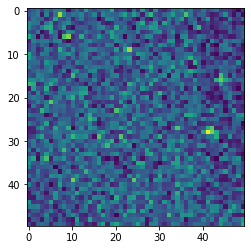

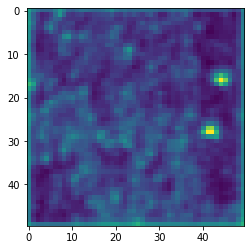

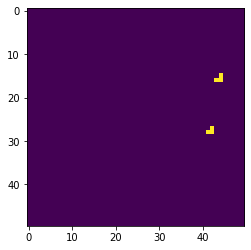

In [68]:
xp, yp = get_patch(xt, yt)
pred = m(torch.tensor(xp.astype('float32')).cuda())
pred = pred[0, 0].cpu().detach().numpy()
plt.imshow(xp[0, 0, :, :, 25])
plt.pause(0.001)
plt.imshow(pred[:, :, 25])
plt.pause(0.001)
plt.imshow(yp[0, 0, :, :, 25])